# Gong et al example

In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib as mpl
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
from matplotlib import rcParams

# customized settings
params = {  # 'backend': 'ps',
    'font.family': 'serif',
    'font.serif': 'Latin Modern Roman',
    'font.size': 7,
    'axes.labelsize': 'medium',
    'axes.titlesize': 'medium',
    'legend.fontsize': 'medium',
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small',
    'savefig.dpi': 150,
    'text.usetex': True, 
    'legend.title_fontsize': 4}
# tell matplotlib about your params
rcParams.update(params)

# set nice figure sizes
fig_width_pt = 433.62 # Get this from LaTeX using \showthe\columnwidth
golden_mean = (np.sqrt(5.) - 1.) / 2.  # Aesthetic ratio
ratio = golden_mean
inches_per_pt = 1. / 72.27  # Convert pt to inches
fig_width = fig_width_pt * inches_per_pt  # width in inches
fig_height = fig_width*ratio  # height in inches
fig_size = [fig_width,fig_height]
rcParams.update({'figure.figsize': fig_size})

Define time horizon, initial condition, and target state.

In [2]:
T = 1
true_x0 = torch.tensor([0.,1.,0.])
t = torch.linspace(0., T, 1000)
target_x = torch.tensor([1.,1.])
B = torch.tensor([0.0,1.0,0.0])
C = torch.tensor([0.0,0.0,1.0])

Define neural ODE with control term.

In [5]:
class ODE_func(nn.Module):

    def __init__(self, number_layers, number_neurons, output_control = False):
        super(ODE_func, self).__init__()

        self.input = nn.Linear(1,number_neurons)
        self.linears = nn.ModuleList([nn.Linear(number_neurons, number_neurons) for i in range(number_layers)])
        self.output = nn.Linear(number_neurons,1)
        self.number_layers = number_layers
        
        self.output_control = output_control
        
    def forward(self, t, y):
        u = self.input(torch.tensor([t]))
        
        for i in range(self.number_layers):
            u = nn.functional.elu(u)
            u = self.linears[i](u)
        u = nn.functional.elu(u)
        u = self.output(u)
        
        if self.output_control == False:
            return torch.tensor([y[1],-y[1],0.0])+B*u+C*u*y[1]
        else:
            return u

def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight)#constant_(m.weight,val=1e-2)
        torch.nn.init.constant_(m.bias,val=1e-2)

In [6]:
def mse(x,y):
    return np.linalg.norm(x-y)**2

Solve control problem.

In [8]:
net_params = []
best_loss_arr = []
J_arr = []
u_mse = []
mu_arr = np.logspace(-6,-1,10)
eta = 1e-1

number_layers = [8]#[2,4,8,16,32,64]
for mu in mu_arr:
    torch.manual_seed(10)
    for number_layer in number_layers:
        func = ODE_func(number_layer, 6)
        func.apply(weights_init)

        optimizer = optim.Adam(func.parameters(), lr=eta)

        best_model = func
        loss_new = 1e9
        L = 1e9
        J = 1e9

        for itr in range(1, 100):

            optimizer.zero_grad()
            pred_x = odeint(func, true_x0, t, method='dopri5')
            loss = ((pred_x[-1][:2] - target_x)**2).sum()+mu*pred_x[-1][2]
            loss.backward()
            optimizer.step()

            if loss < loss_new:
                best_model = func
                loss_new = loss
                J = pred_x[-1][2]
                L = float(((pred_x[-1][:2] - target_x)**2).sum())

            if itr % 10 == 0:
                print(itr, loss, pred_x[-1][0], pred_x[-1][1], pred_x[-1][2])

            itr += 1

        func = best_model
        func.output_control = True
        u_mse.append(mse(np.array([float(func(x,torch.tensor([0.,0.]))) for x in t]),np.ones(len(t))))
        net_params.append(best_model)
        best_loss_arr.append(L)
        J_arr.append(J)

10 tensor(0.0323, grad_fn=<AddBackward0>) tensor(0.9996, grad_fn=<SelectBackward>) tensor(1.1796, grad_fn=<SelectBackward>) tensor(1.2027, grad_fn=<SelectBackward>)
20 tensor(0.0120, grad_fn=<AddBackward0>) tensor(1.0941, grad_fn=<SelectBackward>) tensor(1.0557, grad_fn=<SelectBackward>) tensor(1.2554, grad_fn=<SelectBackward>)
30 tensor(0.0008, grad_fn=<AddBackward0>) tensor(1.0269, grad_fn=<SelectBackward>) tensor(0.9937, grad_fn=<SelectBackward>) tensor(1.0486, grad_fn=<SelectBackward>)
40 tensor(0.0019, grad_fn=<AddBackward0>) tensor(0.9901, grad_fn=<SelectBackward>) tensor(0.9579, grad_fn=<SelectBackward>) tensor(0.9396, grad_fn=<SelectBackward>)
50 tensor(0.0004, grad_fn=<AddBackward0>) tensor(1.0159, grad_fn=<SelectBackward>) tensor(1.0117, grad_fn=<SelectBackward>) tensor(1.0439, grad_fn=<SelectBackward>)
60 tensor(0.0002, grad_fn=<AddBackward0>) tensor(1.0124, grad_fn=<SelectBackward>) tensor(1.0094, grad_fn=<SelectBackward>) tensor(1.0344, grad_fn=<SelectBackward>)
70 tensor(

50 tensor(0.0010, grad_fn=<AddBackward0>) tensor(1.0153, grad_fn=<SelectBackward>) tensor(1.0113, grad_fn=<SelectBackward>) tensor(1.0423, grad_fn=<SelectBackward>)
60 tensor(0.0008, grad_fn=<AddBackward0>) tensor(1.0116, grad_fn=<SelectBackward>) tensor(1.0087, grad_fn=<SelectBackward>) tensor(1.0321, grad_fn=<SelectBackward>)
70 tensor(0.0007, grad_fn=<AddBackward0>) tensor(1.0008, grad_fn=<SelectBackward>) tensor(0.9921, grad_fn=<SelectBackward>) tensor(0.9939, grad_fn=<SelectBackward>)
80 tensor(0.0006, grad_fn=<AddBackward0>) tensor(1.0025, grad_fn=<SelectBackward>) tensor(0.9956, grad_fn=<SelectBackward>) tensor(1.0005, grad_fn=<SelectBackward>)
90 tensor(0.0006, grad_fn=<AddBackward0>) tensor(1.0048, grad_fn=<SelectBackward>) tensor(0.9998, grad_fn=<SelectBackward>) tensor(1.0095, grad_fn=<SelectBackward>)
10 tensor(0.0343, grad_fn=<AddBackward0>) tensor(0.9985, grad_fn=<SelectBackward>) tensor(1.1780, grad_fn=<SelectBackward>) tensor(1.1988, grad_fn=<SelectBackward>)
20 tensor(

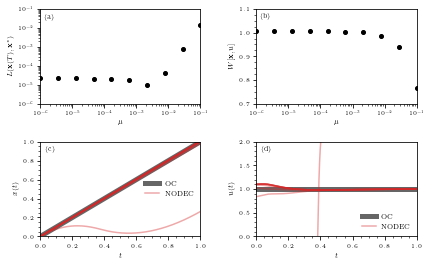

In [10]:
fig, ax = plt.subplots(ncols=2, nrows=2)
fig.patch.set_facecolor('white')

ax[0,0].text(0.13*1e-5,0.03,r"(a)")
ax[0,0].plot(mu_arr,best_loss_arr,'ko',markersize=4)
ax[0,0].set_xlabel(r'$\mu$')
ax[0,0].set_ylabel(r'$L(\mathbf{x}(T),\mathbf{x}^*)$')
ax[0,0].set_xscale('log')
ax[0,0].set_yscale('log')
ax[0,0].set_xlim(1e-6,1e-1)
ax[0,0].set_ylim(1e-6,1e-1)

ax[0,1].text(0.13*1e-5,0.9*0.4+0.7,r"(b)")
ax[0,1].plot(mu_arr,J_arr,'ko',markersize=4)
ax[0,1].set_xlabel(r'$\mu$')
ax[0,1].set_ylabel(r'$W[\mathbf{x},u]$')
ax[0,1].set_xscale('log')
ax[0,1].set_xlim(1e-6,1e-1)
ax[0,1].set_ylim(0.7,1.1)
ax[0,1].set_yticks([0.7,0.8,0.9,1.0,1.1])
ax[0,1].yaxis.set_minor_locator(ticker.MultipleLocator(0.025))

ax[1,0].text(0.03,0.9,r"(c)")
ax[1,0].plot(t,t,label='OC',color='k',alpha=0.6,linewidth=5)
ax[1,0].set_xlabel(r'$t$')
ax[1,0].set_ylabel(r'$x(t)$')
ax[1,0].set_xlim(0,1)
ax[1,0].set_ylim(0,1)
ax[1,0].xaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax[1,0].yaxis.set_minor_locator(ticker.MultipleLocator(0.05))

ax[1,1].text(0.03,0.9*2,r"(d)")
ax[1,1].plot(t,np.ones_like(t),label='OC',color='k',alpha=0.6,linewidth=5)
ax[1,1].set_xlabel(r'$t$')
ax[1,1].set_ylabel(r'$u(t)$')
ax[1,1].set_xlim(0,1)
ax[1,1].set_yticks([0,0.5,1.0,1.5,2.0])
ax[1,1].xaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax[1,1].yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

for i in range(len(net_params)):
    func = net_params[i]
    func.output_control = False
    pred_x = odeint(func, true_x0, t, method='dopri5')
    ax[1,0].plot(t,[pred_x[i][0] for i in range(len(pred_x))],color="tab:red",alpha=0.4)

    func.output_control = True
    ax[1,1].plot(t,[func(x,torch.tensor([0.,0.])) for x in t],color="tab:red",alpha=0.4)
    ax[1,1].set_ylim(0,2)

ax[1,0].plot(100,100,label='NODEC',color="tab:red",alpha=0.4)
ax[1,1].plot(100,100,label='NODEC',color="tab:red",alpha=0.4)
ax[1,0].legend(loc=5,frameon=False)
ax[1,1].legend(loc=4,frameon=False)

plt.tight_layout()
plt.subplots_adjust(wspace=0.35,hspace=0.4)
plt.savefig("ann_moving_particle_loss_2.png",dpi=300)

plt.show()